## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path) 

In [3]:
data = pd.read_csv("Cleaned data\data.csv")

In [4]:
# drop columns
df = data.drop(columns=[
    "DATE","MONTHDATE","FORECASTDEMAND","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,46.93,4,21.95
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,46.93,5,21.00
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,46.93,6,21.55
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,46.93,0,20.90
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,46.93,1,19.05


In [5]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,46.93,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,46.93,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,46.93,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,46.93,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,46.93,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Define a function to create the sliding window dataset
def create_sliding_window(data, window_size, step_size, target):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X_window = []
        for j in range(0, window_size, step_size):
            X_window.append(data.iloc[i-j-1, 1:])
        X.append(np.concatenate(X_window, axis=0))
        y.append(data.iloc[i, 1:])
    y2 = [vals[4] for vals in y]
    return np.array(X), np.array(y2)

In [7]:
# Define the window size and step size
target = "TOTALDEMAND"
window_size = 1   # 1 day ahead
step_size = 1     # move the window by 1 day at a time

# Apply the sliding window method to the training and validation sets
X, y = create_sliding_window(df, window_size, step_size, target)

In [8]:
# train test split - use last year to train
train_year = 2022
train_len = len(df[df["YEAR"]<2022])
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]

In [9]:
# define scaler and transform data
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [10]:
# Define the XGBoost model
model = xgb.XGBRegressor()

In [11]:
# hyperparameters
params = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.2, 0.1, 0.05, 0.01],
    'n_estimators': [130, 150, 170, 180, 200, 220]
}

In [12]:
# identify best hyperparameters using gridsearch
grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...lta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                    

In [13]:
# print all results 
print("------ All Results ------- ")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("   %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print("------ End All Results ------- ")

------ All Results ------- 
   0.795 (+/-0.035) for {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 130}
   0.797 (+/-0.035) for {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150}
   0.797 (+/-0.033) for {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 170}
   0.797 (+/-0.033) for {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 180}
   0.797 (+/-0.032) for {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}
   0.798 (+/-0.033) for {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 220}
   0.789 (+/-0.054) for {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 130}
   0.786 (+/-0.056) for {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}
   0.785 (+/-0.059) for {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 170}
   0.784 (+/-0.060) for {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 180}
   0.783 (+/-0.063) for {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
   0.782 (+/-0.063) for {'learning_rate': 0.2, '

In [14]:
# best hyperparameters and score
print("Best Hyperparameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_) 

Best Hyperparameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
Best Score:  0.8044247093437897


In [15]:
# train model using best hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [16]:
# predictions on test data 
y_pred = best_model.predict(X_test)

In [23]:
# print model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# accuracy = accuracy_score(y_test, y_pred)

print("Mean Absolute Error: {:.2f}".format(mae))
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Squared Error: {:.2f}".format(rmse))
# print("Accuracy: {:.2f}".format(accuracy)) 

Mean Absolute Error: 328.13
Mean Squared Error: 209791.86
Root Mean Squared Error: 458.03


#### Plot Accuracy

In [24]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

In [25]:
df_lim = data[data["YEAR"]==2022]
df_lim = df_lim.tail(len(df_lim) - window_size)

In [26]:
Date = df_lim.DATE
Demand = df_lim.TOTALDEMAND
Pred = df_lim['Prediction'] = y_pred

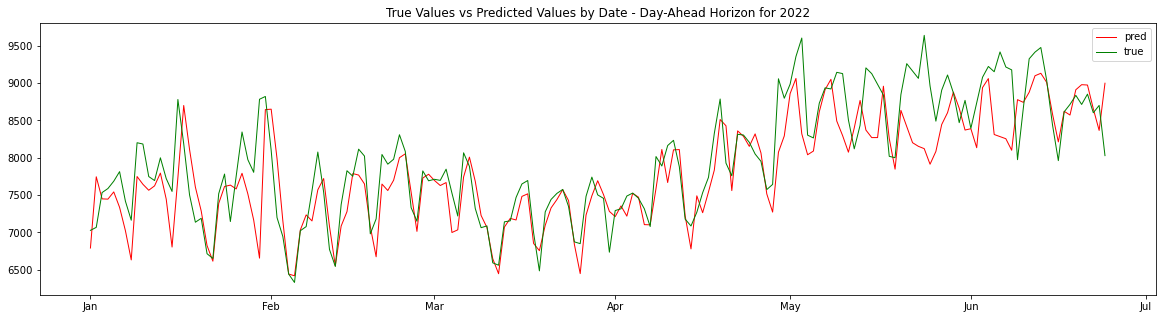

In [27]:
fig, ax = plt.subplots(figsize=(20,5))
pred = ax.plot(Date, Pred, linewidth=1, color='red')
true = ax.plot(Date, Demand, linewidth=1, color='green')
ax.legend([pred, true], labels=["pred", "true"])
ax.set_title("True Values vs Predicted Values by Date - Day-Ahead Horizon for 2022")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()